This notebook aims to optimize the parameters of our CNN + MLP models

In [151]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter
import optuna
import torch.optim as optim
import torch.nn.functional as F
from helpers import *

1. Load the dataset 

In [152]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [153]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])
test_df['length'] = test_df['protein_sequence'].str.len()

2. Translate Amino-acids to numbers and create a One-Channel array for each sequence

In [154]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()

In [155]:
# fix max_length to be 500
max_length = 500

#drop rows that exceeds this value

train_df = train_df[train_df['length'] < max_length]



In [156]:
len(train_df)

20510

In [157]:
# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))

In [158]:
#final dataframe 
train_df.head()

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [159]:
df = train_df.copy()

In [160]:
df = df.reset_index(drop=True)

In [161]:
test_df = test_df.reset_index(drop=True)

3. Split to train and validation sets

In [162]:
#split padded_train_df into train and validation sets (will be put in a function later)
train_df , val_df = split_train_test(df,frac=0.8)


4. Create the CNN +MLP model

In [163]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [164]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100


In [165]:
# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [166]:
class Conv1D_OneChannel(nn.Module):

    def __init__(self, trial, n_filters, size_pooling, drop_f, nb_num, n_linear):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(


            nn.Conv1d(20, n_filters[0],kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            

            nn.Conv1d(n_filters[0], n_filters[1],kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            
            nn.Conv1d(n_filters[1], n_filters[2],kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            
            nn.Conv1d(n_filters[2], n_filters[3],kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
         
            torch.nn.MaxPool1d(3), 
            
            torch.nn.Flatten(),
            torch.nn.Dropout2d(p=0.5, inplace=False),
            nn.AdaptiveAvgPool1d(128),

        )
        
        self.numerical = nn.Sequential(
            nn.Linear(2, nb_num),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(nb_num, 2),
            nn.ReLU(),
            
        )
        self.mlp = nn.Sequential(
            nn.Linear(130, n_linear[0]),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ReLU(),
 
            nn.Linear(n_linear[0], n_linear[1]),
            nn.ReLU(),
            nn.Linear(n_linear[1], n_linear[2]),
            nn.ReLU(),
            nn.Linear(n_linear[2], 1),
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

In [167]:
def train(model, optimizer):
    
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (seq, target,num) in enumerate(train_loader):
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(seq,num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
   
    #print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss 


def test( model):
  
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    print(
        f"Test set: Average loss: {test_loss:0.2e} "
    )

    return test_loss

    

#Objective function to be trained with optuna
def objective(trial):
    
    
    # Define range of values to be tested for the hyperparameters
    
    n_filters = []
    for i in range(4):
        n_filters.append(trial.suggest_int(f'n_filter_{i}', 4, 128, 5)) 
    
    #n_filters = trial.suggest_int(f'n_filter_', 4, 128, 5)
    
    
    #n_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(10)]              # Number of filters for the convolutional layers
    size_pooling = trial.suggest_int("size_pooling", 2, 12)  # Number of neurons of FC1 layer
    drop_f = trial.suggest_float("drop_f", 0.2, 0.5)     # Dropout for convolutional layer 2
    nb_num = trial.suggest_int("nb_num", 2, 100)
    
    n_linear = []
    for i in range(3):
        n_linear.append(trial.suggest_int(f'n_linear_{i}', 2, 300)) 

    # Generate the model
    model = Conv1D_OneChannel(trial, n_filters, size_pooling, drop_f, nb_num, n_linear)
    model = model.to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model
    for epoch in range(n_epochs):
        train(model, optimizer)  # Train the model
        loss = test(model)   # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(loss, epoch)
        # Handle pruning based on the intermediate value.
        #if trial.should_prune():
            #raise optuna.exceptions.TrialPruned()

    return loss



    criterion=nn.MSELoss()
    n_epochs=100
    # Use cuda if available 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 
    # Parameters for the optimization
    n_epochs = 10                         
    batch_size_train = 64                 
    batch_size_test = 1000                
    number_of_trials = 20                
    limit_obs = True                      

    
    # -------------------------------------------------------------------------

    # Make runs repeatable
    random_seed = 1
    torch.backends.cudnn.enabled = False 
    torch.manual_seed(random_seed)

    train_loader = train_dl

    test_loader = val_dl

    # Create an Optuna study to minimize the loss
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=number_of_trials)

    
    #Results

    trial = study.best_trial
    print("Best trial:")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    
    # Display results in a dataframe
    print("\nOverall Results (ordered by accuracy):\n {}".format(df))




In [168]:
"""Test set: Average loss: 9.78e+01 
Best trial:
  Value:  89.60638269277719
  Params: 
    n_filter_0: 39
    n_filter_1: 99
    n_filter_2: 9
    n_filter_3: 74
    size_pooling: 6
    drop_f: 0.3484731752499901
    nb_num: 77
    n_linear_0: 12
    n_linear_1: 146
    n_linear_2: 225
    optimizer: Adam
    lr: 0.002251355055480722"""
lr=0.002251355055480722
model = Conv1D_OneChannel(trial, (39,99,9,74), 6, 0.3484731752499901, 77, (12,146,225))
optimizer = Adam(model.parameters(), lr=lr)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    #torch.save(model.state_dict(), f"2-Conv1d_OneHot_model_{epoch}.pth")


In [169]:
#Train model
    
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
   


/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Average loss: 1.33e+02 
Test set: Average loss: 1.19e+02 
Test set: Average loss: 1.15e+02 
Test set: Average loss: 1.11e+02 
Test set: Average loss: 1.10e+02 
Test set: Average loss: 1.12e+02 
Test set: Average loss: 1.08e+02 
Test set: Average loss: 1.04e+02 
Test set: Average loss: 9.84e+01 
Test set: Average loss: 9.22e+01 
Test set: Average loss: 9.27e+01 
Test set: Average loss: 9.46e+01 
Test set: Average loss: 1.04e+02 
Test set: Average loss: 8.98e+01 
Test set: Average loss: 9.21e+01 
Test set: Average loss: 1.04e+02 
Test set: Average loss: 9.55e+01 
Test set: Average loss: 8.78e+01 
Test set: Average loss: 8.48e+01 
Test set: Average loss: 8.57e+01 
Test set: Average loss: 8.73e+01 
Test set: Average loss: 8.55e+01 
Test set: Average loss: 8.47e+01 
Test set: Average loss: 8.62e+01 
Test set: Average loss: 8.93e+01 
Test set: Average loss: 8.35e+01 
Test set: Average loss: 8.16e+01 
Test set: Average loss: 8.34e+01 
Test set: Average loss: 8.30e+01 
Test set: Aver

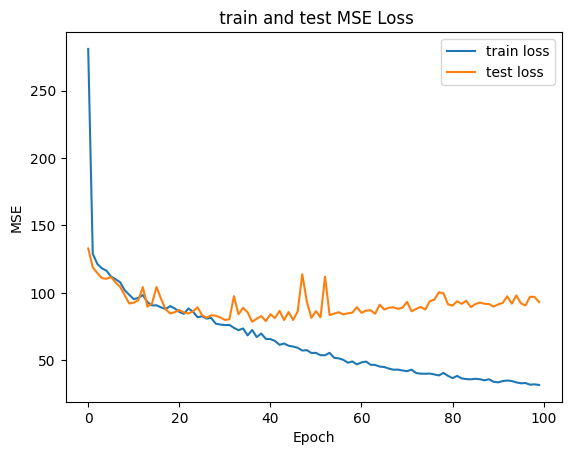

In [170]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('6_optimized_CNN_loss.png')


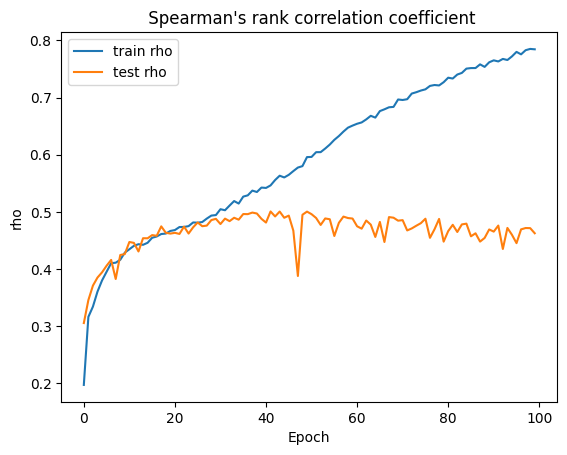

In [171]:
#Spearman's coefficient plot
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('6-Optimized_CNN_tho.png')

In [172]:
#Prediction for Kaggle's submission
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders
sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)

/home/ml4science/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [173]:
sub = pd.read_csv(path+ 'test.csv',index_col='seq_id')
sub['tm']=submission_df
sub = sub.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('6-Optimized_CNN.csv', index=True)

In [174]:
submission_df

array([[49.270527],
       [48.80561 ],
       [49.09138 ],
       ...,
       [49.286224],
       [49.073917],
       [48.98869 ]], dtype=float32)